# Omega model: Danish morphologial tagger

## Imports and installs

In [ ]:
!pip install pandas scikit-learn transformers[torch] wandb datasets numpy

In [ ]:
import os

from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, EvalPrediction
import wandb

In [ ]:
wandb.init(project="omega-danish")

wandb: Currently logged in as: ignacioct_ (ignacio_at_ai). Use `wandb login --relogin` to force relogin


## Load the dataset

In [ ]:
def combine_dataset(path_file1:str, path_file2:str) -> pd.DataFrame:

    df_1 = pd.read_csv(path_file1, sep="\t", header=None)
    df_2 = pd.read_csv(path_file2, sep="\t", header=None)

    df = pd.concat([df_1, df_2])

    # reset the index
    df.reset_index(drop=True, inplace=True)

    # rename columns
    df.rename(columns={0: 'lemma', 1: 'inflected form', 2: 'PoS'}, inplace=True)

    # shuffle columns
    df = df.sample(frac=1, axis=0, random_state=123)

    return df

danish_df = combine_dataset("danish_2017_task1.txt", "danish_2017_task2.txt")
danish_df.head()

,lemma,inflected form,PoS
715,dommer,dommere,N;INDF;NOM;PL
9671,grotesk,grotesks,N;INDF;GEN;SG
7444,ventil,ventilens,N;DEF;NOM;SG
7917,affaldscontainer,affaldscontainernes,N;DEF;NOM;PL
8903,flod,flodens,N;DEF;NOM;SG


## Preprocess

### Getting multilabel tags

First, we need to obtain all labels present in the dataset

In [ ]:
morphological_tags = {}

for index, row in danish_df.iterrows():
  pos_tags = row["PoS"]

  # Split the string with tags and create a list
  list_tags = pos_tags.split(";")

  # Append the tags into the set
  for tag in list_tags:
    if tag not in morphological_tags.keys():
      morphological_tags[tag] = 1
    else:
      morphological_tags[tag] += 1

# Order the dictionary in a list in alphabetical order
morphological_tags_list = sorted(morphological_tags.keys(), key=lambda x: x[0])

print(morphological_tags)
print(morphological_tags_list)

{'N': 10514, 'INDF': 6990, 'NOM': 7032, 'PL': 5303, 'GEN': 3482, 'SG': 5211, 'DEF': 3524, 'V': 520, 'PASS': 242, 'IND': 346, 'PST': 257, 'ACT': 447, 'NFIN': 89, 'V.PTCP': 169, 'PRS': 258, 'IMP': 85}
['ACT', 'DEF', 'GEN', 'INDF', 'IND', 'IMP', 'N', 'NOM', 'NFIN', 'PL', 'PASS', 'PST', 'PRS', 'SG', 'V', 'V.PTCP']


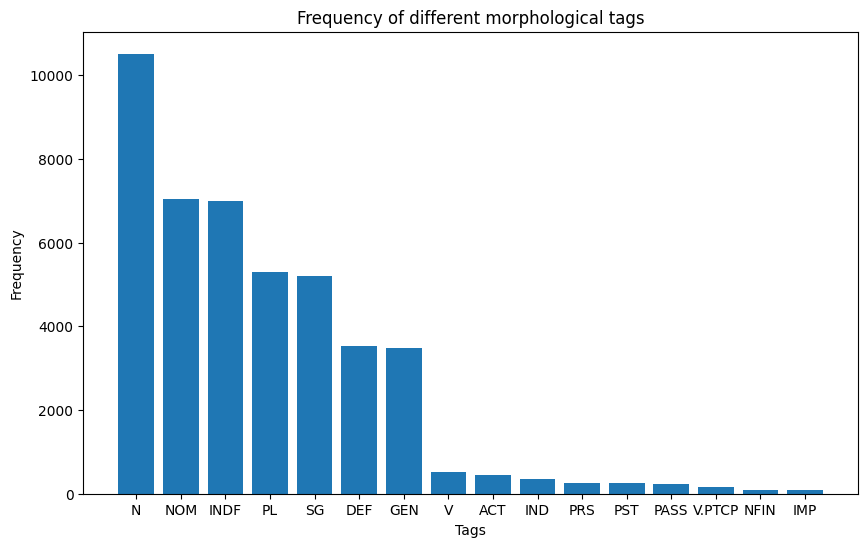

In [ ]:
# Sort the dictionary by value
sorted_dict = {k: v for k, v in sorted(morphological_tags.items(), key=lambda x: x[1], reverse=True)}

# Plot the sorted dictionary as a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(list(sorted_dict), [v for k, v in sorted_dict.items()])
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of different morphological tags')
plt.show()

### Create the one-hot encoding

In [ ]:
danish_df

,lemma,inflected form,PoS
715,dommer,dommere,N;INDF;NOM;PL
9671,grotesk,grotesks,N;INDF;GEN;SG
7444,ventil,ventilens,N;DEF;NOM;SG
7917,affaldscontainer,affaldscontainernes,N;DEF;NOM;PL
8903,flod,flodens,N;DEF;NOM;SG
...,...,...,...
9785,karisma,karisma,N;INDF;NOM;SG
7763,radiobil,radiobiler,N;INDF;NOM;PL
5218,hest,hestenes,N;DEF;NOM;PL
1346,D-mark,D-mark,N;INDF;NOM;SG


In [ ]:
# First, we need to add the label column
danish_df.insert(2, 'labels', 'default')

# Now, we need to populate the columns
for index, row in danish_df.iterrows():
  pos_tags = row["PoS"].split(";")
  one_hot = [0.0]*16
  for obtained_tag in pos_tags:
    for list_tag in morphological_tags_list:

      if list_tag == obtained_tag:
        one_hot[morphological_tags_list.index(list_tag)] = 1.0
  danish_df.at[index, "labels"] = one_hot

# And finally, we can remove the original PoS column
danish_df = danish_df.drop("PoS", axis=1)
danish_df.head()

,lemma,inflected form,labels
715,dommer,dommere,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
9671,grotesk,grotesks,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
7444,ventil,ventilens,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
7917,affaldscontainer,affaldscontainernes,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
8903,flod,flodens,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."


### Unifying lemma and inflected form into text

In [ ]:
# First, we need to add the text column
danish_df.insert(0, 'text', 'default')

# Now, we need to populate the columns
for index, row in danish_df.iterrows():

  danish_df.at[index, "text"] = row["lemma"] + "[SEP]" + row["inflected form"]

# And finally, we can remove the original columns
danish_df = danish_df.drop("lemma", axis=1)
danish_df = danish_df.drop("inflected form", axis=1)
danish_df.head()

,text,labels
715,dommer[SEP]dommere,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
9671,grotesk[SEP]grotesks,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
7444,ventil[SEP]ventilens,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
7917,affaldscontainer[SEP]affaldscontainernes,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
8903,flod[SEP]flodens,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."


### Splitting Dataset

In [ ]:
train_df, temp_df = train_test_split(danish_df, test_size=0.3, random_state=42)

# Now, temp_df contains 30% of the original data
# Next, split temp_df into dev and test sets (50% of the remaining data each)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Check the sizes of the resulting sets
print("Train set size:", len(train_df))
print("Dev set size:", len(dev_df))
print("Test set size:", len(test_df))

Train set size: 7842
Dev set size: 1680
Test set size: 1681


### Tranforming Pandas DF into HG Dataset

In [ ]:
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)

danish_ds = DatasetDict({
    'train': train_ds,
    'test': test_ds,
    'dev': dev_ds})

### Tokenizing the text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
danish_ds = danish_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/7842 [00:00<?, ? examples/s]

Map:   0%|          | 0/1681 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [ ]:
danish_ds["train"][0]

{'text': 'pomme frite[SEP]pomme fritens',
 'labels': [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0],
 '__index_level_0__': 2707,
 'input_ids': [101,
  13433,
  20058,
  10424,
  4221,
  102,
  13433,
  20058,
  10424,
  4221,
  3619,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Using Data Collator to create batches

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Fine-tune with trainer

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=16,
    id2label={index: word for index, word in enumerate(morphological_tags_list)},
    label2id={word: index for index, word in enumerate(morphological_tags_list)},
    problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model.config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "ACT",
    "1": "DEF",
    "2": "GEN",
    "3": "INDF",
    "4": "IND",
    "5": "IMP",
    "6": "N",
    "7": "NOM",
    "8": "NFIN",
    "9": "PL",
    "10": "PASS",
    "11": "PST",
    "12": "PRS",
    "13": "SG",
    "14": "V",
    "15": "V.PTCP"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ACT": 0,
    "DEF": 1,
    "GEN": 2,
    "IMP": 5,
    "IND": 4,
    "INDF": 3,
    "N": 6,
    "NFIN": 8,
    "NOM": 7,
    "PASS": 10,
    "PL": 9,
    "PRS": 12,
    "PST": 11,
    "SG": 13,
    "V": 14,
    "V.PTCP": 15
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0

In [ ]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=danish_ds["train"],
    eval_dataset=danish_ds["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.233800,0.091047,0.951777,0.965957,0.870238
2,0.070400,0.059457,0.961259,0.971409,0.885119
3,0.046100,0.051125,0.969268,0.978101,0.904762
4,0.033300,0.038565,0.974525,0.981390,0.901786
5,0.025000,0.037454,0.977406,0.983536,0.914881
6,0.020700,0.034395,0.980024,0.986186,0.926786
7,0.018300,0.034432,0.981005,0.986909,0.930952


TrainOutput(global_step=3437, training_loss=0.06395410166461002, metrics={'train_runtime': 8087.8624, 'train_samples_per_second': 6.787, 'train_steps_per_second': 0.425, 'total_flos': 216204021812928.0, 'train_loss': 0.06395410166461002, 'epoch': 7.0})

In [ ]:
trainer.save_model("best_omega_model")

In [ ]:
!ls

best_omega_model  danish_2017_task1.txt  danish_2017_task2.txt	results  sample_data  wandb


In [ ]:
!zip -r /content/best_omega_model.zip /content/best_omega_model

  adding: content/best_omega_model/ (stored 0%)
  adding: content/best_omega_model/training_args.bin (deflated 50%)
  adding: content/best_omega_model/tokenizer_config.json (deflated 76%)
  adding: content/best_omega_model/model.safetensors (deflated 8%)
  adding: content/best_omega_model/config.json (deflated 53%)
  adding: content/best_omega_model/tokenizer.json (deflated 71%)
  adding: content/best_omega_model/vocab.txt (deflated 53%)
  adding: content/best_omega_model/special_tokens_map.json (deflated 42%)


In [ ]:
from google.colab import files
files.download("/content/file.zip")

## Loading model and testing valid and test splits

In [ ]:
omega = AutoModelForSequenceClassification.from_pretrained("best_omega_model")
tokenizer = AutoTokenizer.from_pretrained("best_omega_model")

In [ ]:
trainer.evaluate(danish_ds["test"])

{'eval_loss': 0.03976890817284584,
 'eval_f1': 0.9759687593872035,
 'eval_roc_auc': 0.98354481763327,
 'eval_accuracy': 0.916716240333135,
 'eval_runtime': 89.5302,
 'eval_samples_per_second': 18.776,
 'eval_steps_per_second': 1.184,
 'epoch': 7.0}